In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.spatial.transform import Rotation as R
import torch
from mpl_toolkits import mplot3d

# 3DOF transform
### T1 and T2 are homogenous transformation matrix w.r.t. global frame of point p1 and p2
### To represent point in the frame of p1 simply take inverse of T1 and dot product with the point (note this will only provide the points x,y coordinates in the frame of p1)

In [2]:
p1 = [1, 1, 0]
p2 = [0, 0, 0]

T1 = np.array([[np.cos(p1[2]), -np.sin(p1[2]), p1[0]],
               [np.sin(p1[2]),  np.cos(p1[2]), p1[1]],
               [0,               0,               1]])

T2 = np.array([[np.cos(p2[2]), -np.sin(p2[2]), p2[0]],
               [np.sin(p2[2]),  np.cos(p2[2]), p2[1]],
               [0,               0,               1]])

T1_inv = np.linalg.inv(T1)
print("x and y coordinates: ", T1.dot(T2.dot(np.array([0, 0, 1])))[:2] )

tf2_mat = T2 @ T1_inv
print("theta: ", np.arctan2(tf2_mat[1,0], tf2_mat[0,0]))

x and y coordinates:  [1. 1.]
theta:  0.0


## Function for batch transform of SE2 pose using numpy

In [3]:
def batch_process_se2_transforms(p1_batch, p2_batch):
    # Validate inputs
    if p1_batch.shape != p2_batch.shape or p1_batch.shape[-1] != 3:
        raise ValueError("Both batches must be of the same shape and contain 3 elements per pose")

    # Number of transformations in the batch
    batch_size = p1_batch.shape[0]

    # Preallocate arrays for transformations
    transformed_positions = np.zeros((batch_size, 3))

    # Process each transformation in the batch
    for i in range(batch_size):
        p1 = p1_batch[i]
        p2 = p2_batch[i]

        # Construct SE2 matrices
        T1 = np.array([[np.cos(p1[2]), -np.sin(p1[2]), p1[0]],
                       [np.sin(p1[2]),  np.cos(p1[2]), p1[1]],
                       [0,              0,                1]])

        T2 = np.array([[np.cos(p2[2]), -np.sin(p2[2]), p2[0]],
                       [np.sin(p2[2]),  np.cos(p2[2]), p2[1]],
                       [0,              0,                1]])

        # Inverse of T1 and transformation
        T1_inv = np.linalg.inv(T1)
        tf2_mat = T2 @ T1_inv

        # Extract x, y and angle
        transformed_positions[i, :2] = (T1_inv @ T2 @ np.array([0, 0, 1]))[:2]
        transformed_positions[i, 2] = np.arctan2(tf2_mat[1, 0], tf2_mat[0, 0])

    return transformed_positions

In [4]:
poses = []
for i in range(1001):
   poses.append([ i, 0, np.pi/500 * i]) 

poses = np.array(poses)
poses.shape

se2p_1 = poses[0:-1]
se2p_2 = poses[1:]

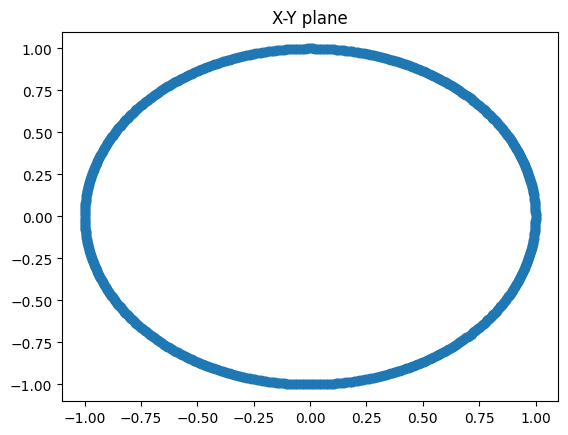

In [5]:
out = batch_process_se2_transforms(se2p_1, se2p_2)
plt.title("X-Y plane")
plt.scatter(out[:, 0], out[:, 1]) 
plt.show()

In [6]:
def batch_process_se2_transforms_torch(p1_batch, p2_batch):
    # Ensure the inputs are tensors
    p1_batch = torch.tensor(p1_batch, dtype=torch.float32)
    p2_batch = torch.tensor(p2_batch, dtype=torch.float32)

    # Validate inputs
    if p1_batch.shape != p2_batch.shape or p1_batch.shape[-1] != 3:
        raise ValueError("Both batches must be of the same shape and contain 3 elements per pose")

    # Extract components
    x1, y1, theta1 = p1_batch[:, 0], p1_batch[:, 1], p1_batch[:, 2]
    x2, y2, theta2 = p2_batch[:, 0], p2_batch[:, 1], p2_batch[:, 2]

    # Construct SE2 matrices
    zeros = torch.zeros_like(x1)
    ones = torch.ones_like(x1)
    T1 = torch.stack([torch.stack([torch.cos(theta1), -torch.sin(theta1), x1]),
                        torch.stack([torch.sin(theta1),  torch.cos(theta1), y1]),
                        torch.stack([zeros, zeros, ones])], dim=-1).permute(1,2,0)

    T2 = torch.stack([torch.stack([torch.cos(theta2), -torch.sin(theta2), x2]),
                        torch.stack([torch.sin(theta2),  torch.cos(theta2), y2]),
                        torch.stack([zeros, zeros, ones])], dim=-1).permute(1,2,0)

    # Inverse of T1 and transformation
    T1_inv = torch.inverse(T1)
    tf2_mat = torch.matmul(T2, T1_inv)

    # Extract transformed positions and angles
    transform = torch.matmul(T1_inv, torch.cat((p2_batch[:,:2], ones.unsqueeze(-1)), dim=1).unsqueeze(2)).squeeze()
    transform[:, 2] = torch.atan2(tf2_mat[:, 1, 0], tf2_mat[:, 0, 0])
    
    return transform

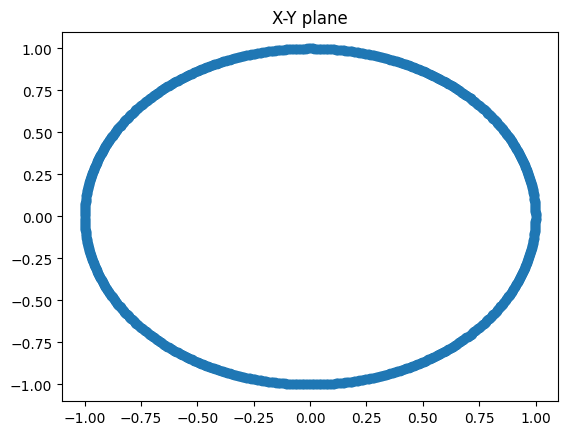

In [7]:
out = batch_process_se2_transforms_torch(se2p_1, se2p_2)
plt.title("X-Y plane")
plt.scatter(out[:, 0], out[:, 1]) 
plt.show()

# 6DOF Transform (eular angles)

### R1 and R2 are rotation matrix w.r.t. global frame of point p1 and p2
### t1 and t2 are translation matrix w.r.t. global frame of point p1 and p2
### T1 and T2 are homogenous matrix combining R with t expanding the last row 
### To represent point in the frame of p1 simply take inverse of T1 and dot product with the point (note this will only provide the points x,y,z coordinates in the frame of p1)


In [8]:
euler1 = [np.pi/4,np.pi/4, np.pi/4]  # Euler angles for the first point
euler2 = [0, 0, 0]  # Euler angles for the second point

R1 = R.from_euler('xyz', euler1).as_matrix()  # Rotation matrix for the first point
R2 = R.from_euler('xyz', euler2).as_matrix()  # Rotation matrix for the second point

t1 = np.array([[1], [1], [1]])  # Translation for the first point (x, y, z)
t2 = np.array([[2], [2], [1]])  # Translation for the second point (x, y, z)

T1 = np.vstack([np.hstack([R1, t1]), [0, 0, 0, 1]])  # Transformation matrix for the first point
T2 = np.vstack([np.hstack([R2, t2]), [0, 0, 0, 1]])  # Transformation matrix for the second point

T1_inv = np.linalg.inv(T1)

# Apply the transformation
# The second point in its own coordinates is [0, 0, 0, 1] (the origin of its own frame)
P2_in_global = T2.dot(np.array([0, 0, 0, 1]))  # Transform the origin of the second point to global coordinates
P2_in_P1_coordinates = T1_inv.dot(P2_in_global)  # Transform this point into the coordinate system of the first point

np.round(P2_in_P1_coordinates, 5)  # Display the transformed coordinates

array([1.     , 0.70711, 0.70711, 1.     ])

### To get full transform matrix from p1 frame to p2 frame do the dot product or T2 and inverse of T1
### extraction of eular angle from the matrix is complex and hence used scipy rotation package

In [9]:
tf3_mat3 = T2 @ T1_inv

In [10]:
np.degrees(R.from_matrix(tf3_mat3[:-1, :-1]).as_euler('xyz')) 

array([-16.32494994, -58.60028519, -16.32494994])

## Function of transformation of two points using numpy

In [11]:
def robot_frame_transform(p1, p2):
    
    tf = np.zeros(6)
    
    t1 = np.array([ [p1[0]], [p1[1]], [p1[2]] ])
    t2 = np.array([ [p2[0]], [p2[1]], [p2[2]] ])
    
    R1 = R.from_euler('xyz', [ p1[3], p1[4], p1[5] ]).as_matrix()
    R2 = R.from_euler('xyz', [ p2[3], p2[4], p2[5] ]).as_matrix()
    
    T1 = np.vstack([np.hstack([R1, t1]), [0, 0, 0, 1]])
    T2 = np.vstack([np.hstack([R2, t2]), [0, 0, 0, 1]])
    
    T1_inv = np.linalg.inv(T1)
    
    tf[:3] = T1_inv.dot(T2.dot(np.array([0,0,0,1])))[:3]
    
    t_inv = T2 @ T1_inv
    
    tf[3:6] = R.from_matrix(t_inv[:-1, :-1]).as_euler('xyz')
    
    return tf
	

In [12]:
p1 = [1,1,1,0,0,np.pi/2]
p2 = [2,1,1,0,0,0]

robot_frame_transform(p1, p2)

array([ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.57079633e+00])

## function for batch transform using numpy

In [13]:
def to_robot(p1_batch, p2_batch):
    
    # Ensure input dimensions are correct
    if p1_batch.shape != p2_batch.shape or p1_batch.shape[1] != 6:
        raise ValueError("Input batches must be of the same shape and contain 6 elements per pose")
    
    n = p1_batch.shape[0]
    transformations = np.zeros((n, 6))

    # Extract and reshape translation components
    t1 = p1_batch[:, :3].reshape(n, 3, 1)
    t2 = p2_batch[:, :3].reshape(n, 3, 1)
    R1 = R.from_euler('xyz', p1_batch[:, 3:6]).as_matrix()
    R2 = R.from_euler('xyz', p2_batch[:, 3:6]).as_matrix()
    id = np.array([[[0,0,0,1]]]).repeat(n, axis=0)
    T1 = np.concatenate([np.concatenate((R1, t1), axis=2), id], axis=1)
    T2 = np.concatenate([np.concatenate((R2, t2), axis=2), id], axis=1)
    
    # Process rotations
    for i in range(n):
        
        T1_inv = np.linalg.inv(T1[i])
        transformations[i, :3] = (T1_inv @ T2[i] @ np.array([0, 0, 0, 1]))[:3]
        t_inv = T2[i] @ T1_inv
        transformations[i, 3:6] = R.from_matrix(t_inv[:-1, :-1]).as_euler('xyz')

    return transformations

In [14]:
poses = []
for i in range(1000):
   poses.append([ i, i ,i ,np.pi/500 * i, np.pi/500 * i, np.pi/500 * i]) 

poses = np.array(poses)
poses.shape

se3p1 = poses[0:-1]
se3p2 = poses[1:]

se3p1.shape, se3p2.shape

((999, 6), (999, 6))

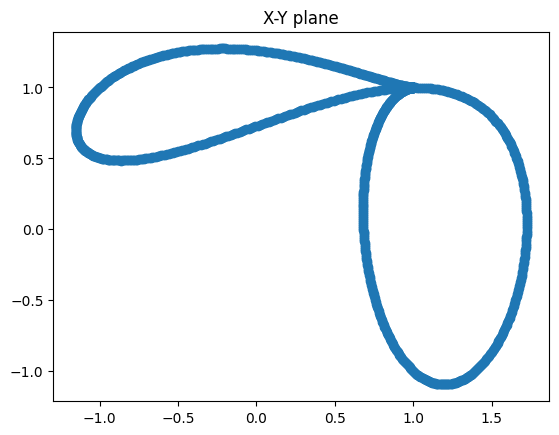

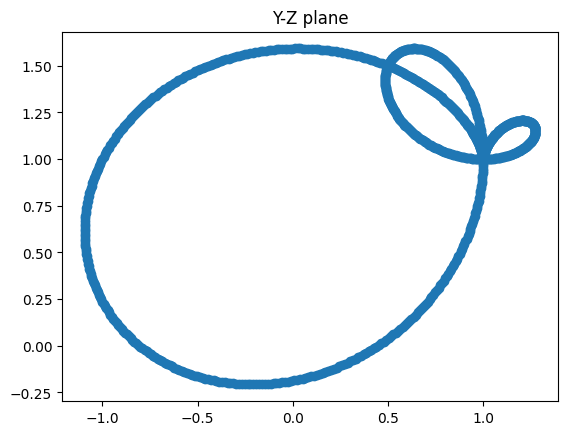

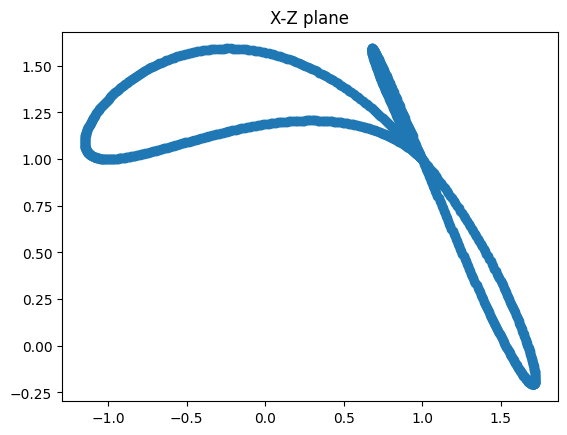

In [15]:
out = to_robot(se3p1, se3p2)
plt.title("X-Y plane")
plt.scatter(out[:, 0], out[:, 1]) 
plt.show()
plt.title("Y-Z plane")
plt.scatter(out[:, 1], out[:, 2])
plt.show()
plt.title("X-Z plane")
plt.scatter(out[:, 0], out[:, 2])


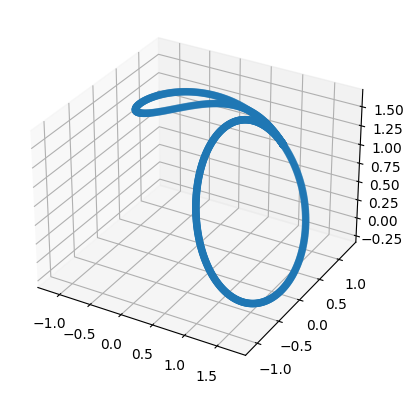

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(out[:,0], out[:,1], out[:,2])

## function for batch transform using torch

In [17]:
def euler_to_rotation_matrix(euler_angles):
    """ Convert Euler angles to a rotation matrix """
    # Compute sin and cos for Euler angles
    cos = torch.cos(euler_angles)
    sin = torch.sin(euler_angles)
    zero = torch.zeros_like(euler_angles[:, 0])
    one = torch.ones_like(euler_angles[:, 0])
    # Constructing rotation matrices (assuming 'xyz' convention for Euler angles)
    R_x = torch.stack([one, zero, zero, zero, cos[:, 0], -sin[:, 0], zero, sin[:, 0], cos[:, 0]], dim=1).view(-1, 3, 3)
    R_y = torch.stack([cos[:, 1], zero, sin[:, 1], zero, one, zero, -sin[:, 1], zero, cos[:, 1]], dim=1).view(-1, 3, 3)
    R_z = torch.stack([cos[:, 2], -sin[:, 2], zero, sin[:, 2], cos[:, 2], zero, zero, zero, one], dim=1).view(-1, 3, 3)

    return torch.matmul(torch.matmul(R_z, R_y), R_x)
    
def extract_euler_angles_from_se3_batch(tf3_matx):
    # Validate input shape
    if tf3_matx.shape[1:] != (4, 4):
        raise ValueError("Input tensor must have shape (batch, 4, 4)")

    # Extract rotation matrices
    rotation_matrices = tf3_matx[:, :3, :3]

    # Initialize tensor to hold Euler angles
    batch_size = tf3_matx.shape[0]
    euler_angles = torch.zeros((batch_size, 3), device=tf3_matx.device, dtype=tf3_matx.dtype)

    # Compute Euler angles
    euler_angles[:, 0] = torch.atan2(rotation_matrices[:, 2, 1], rotation_matrices[:, 2, 2])  # Roll
    euler_angles[:, 1] = torch.atan2(-rotation_matrices[:, 2, 0], torch.sqrt(rotation_matrices[:, 2, 1] ** 2 + rotation_matrices[:, 2, 2] ** 2))  # Pitch
    euler_angles[:, 2] = torch.atan2(rotation_matrices[:, 1, 0], rotation_matrices[:, 0, 0])  # Yaw

    return euler_angles

def to_robot_torch(pose_batch1, pose_batch2):

    if pose_batch1.shape != pose_batch2.shape:
        raise ValueError("Input tensors must have same shape")

    if pose_batch1.shape[-1] != 6:
        raise ValueError("Input tensors must have last dim equal to 6")
        
    """ Assemble a batch of SE3 homogeneous matrices from a batch of 6DOF poses """
    batch_size = pose_batch1.shape[0]
    ones = torch.ones_like(pose_batch2[:, 0])
    transform = torch.zeros_like(pose_batch1)
    T1 = torch.zeros((batch_size, 4, 4), device=pose_batch1.device, dtype=pose_batch1.dtype)
    T2 = torch.zeros((batch_size, 4, 4), device=pose_batch2.device, dtype=pose_batch2.dtype)

    T1[:, :3, :3] = euler_to_rotation_matrix(pose_batch1[:, 3:])
    T2[:, :3, :3] = euler_to_rotation_matrix(pose_batch2[:, 3:])
    T1[:, :3,  3] = pose_batch1[:, :3]
    T2[:, :3,  3] = pose_batch2[:, :3]
    T1[:,  3,  3] = 1
    T2[:,  3,  3] = 1 
    
    T1_inv = torch.inverse(T1)
    tf3_mat = torch.matmul(T2, T1_inv)
    
    transform[:, :3] = torch.matmul(T1_inv, torch.cat((pose_batch2[:,:3], ones.unsqueeze(-1)), dim=1).unsqueeze(2)).squeeze()[:, :3]
    transform[:, 3:] = extract_euler_angles_from_se3_batch(tf3_mat)
    return transform

In [18]:
poses = []
for i in range(1000):
   poses.append([ i, i ,i ,np.pi/500 * i, np.pi/500 * i, np.pi/500 * 0]) 

poses = np.array(poses)
poses.shape

se3p1 = poses[0:-1]
se3p2 = poses[1:]

se3p1.shape, se3p2.shape

((999, 6), (999, 6))

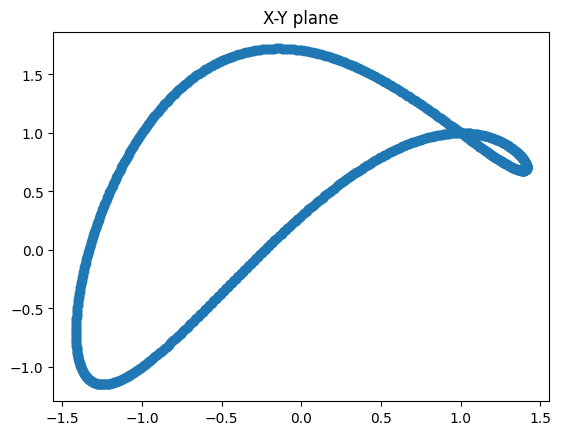

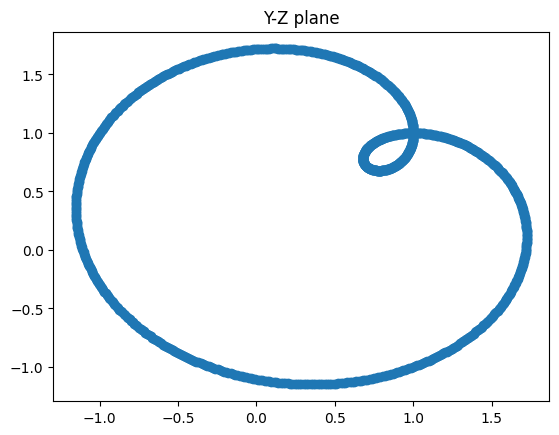

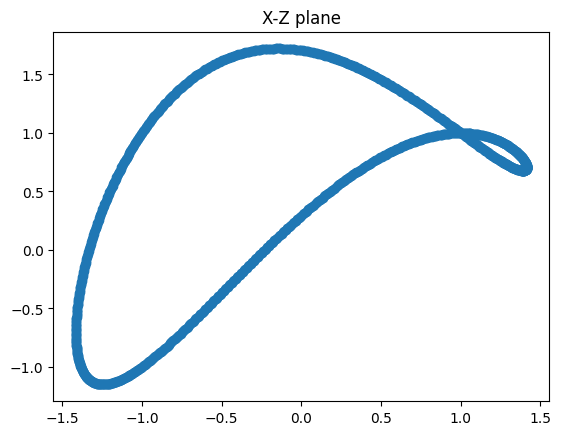

In [19]:
out = to_robot_torch(torch.tensor(se3p1), torch.tensor(se3p2))
plt.title("X-Y plane")
plt.scatter(out[:, 0], out[:, 1]) 
plt.show()
plt.title("Y-Z plane")
plt.scatter(out[:, 1], out[:, 2])
plt.show()
plt.title("X-Z plane")
plt.scatter(out[:, 0], out[:, 2])

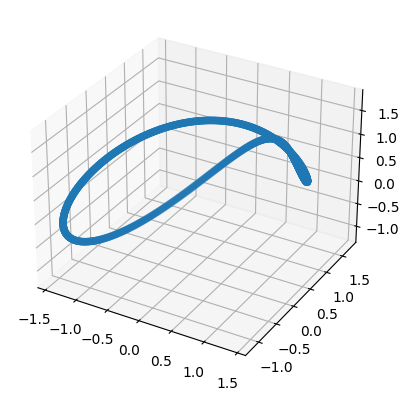

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(out[:,0], out[:,1], out[:,2])

## Batch reverse transform from robot frame to world frame using numpy

In [36]:
se3p1 = []
for i in range(1000):
   se3p1.append([ 10.0, 20.0, 0.0, np.pi/500 *i, np.pi/500 * i, np.pi/500 * i]) 
se3p1 = np.array(se3p1, dtype=np.float32)

se3p2 = []
for i in range(1000):
   se3p2.append([ i, 0.0, 0.0, np.pi/500 *0, np.pi/500 * i, np.pi/500 *0]) 
se3p2 = np.array(se3p2, dtype=np.float32)


se3p1.shape, se3p2.shape

((1000, 6), (1000, 6))

In [37]:
def to_world(Robot_frame, P_relative):
    
    # Ensure input dimensions are correct
    if Robot_frame.shape != P_relative.shape or Robot_frame.shape[1] != 6:
        raise ValueError("Input batches must be of the same shape and contain 6 elements per pose")
    
    n = Robot_frame.shape[0]
    transformations = np.zeros((n, 6))

    # Extract and reshape translation components
    t1 = Robot_frame[:, :3].reshape(n, 3, 1)
    t2 = P_relative[:, :3].reshape(n, 3, 1)
    R1 = R.from_euler('xyz', Robot_frame[:, 3:6]).as_matrix()
    R2 = R.from_euler('xyz', P_relative[:, 3:6]).as_matrix()
    id = np.array([[[0,0,0,1]]]).repeat(n, axis=0)

    T1 = np.concatenate([np.concatenate((R1, t1), axis=2), id], axis=1)
    T2 = np.concatenate([np.concatenate((R2, t2), axis=2), id], axis=1)

    
    # Process rotations
    for i in range(n):
        R_tf = R2[i] @ R1[i]
        transformations[i, :3] = (T1[i] @ T2[i] @ np.array([0, 0, 0, 1]))[:3]
        transformations[i, 3:6] = R.from_matrix(R_tf).as_euler('xyz')

    return transformations

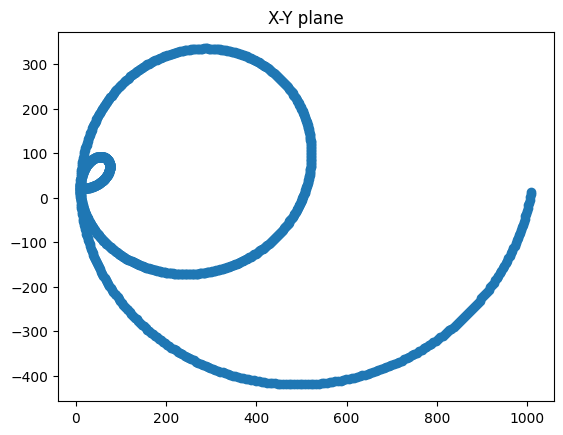

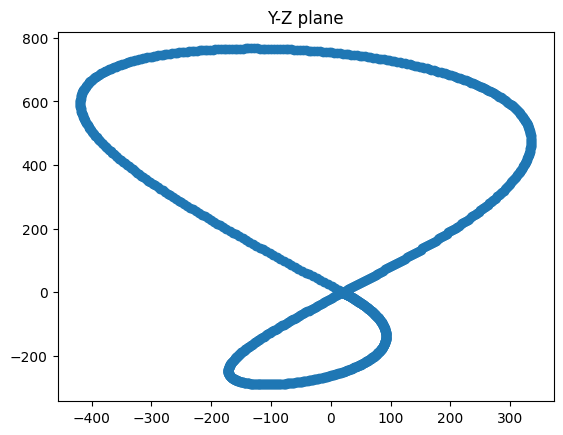

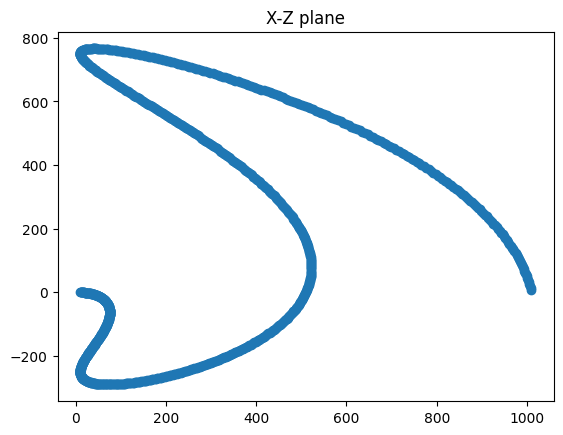

In [38]:
out = np.round(to_world(se3p1, se3p2), 4)
plt.title("X-Y plane")
plt.scatter(out[:, 0], out[:, 1]) 
plt.show()
plt.title("Y-Z plane")
plt.scatter(out[:, 1], out[:, 2])
plt.show()
plt.title("X-Z plane")
plt.scatter(out[:, 0], out[:, 2])

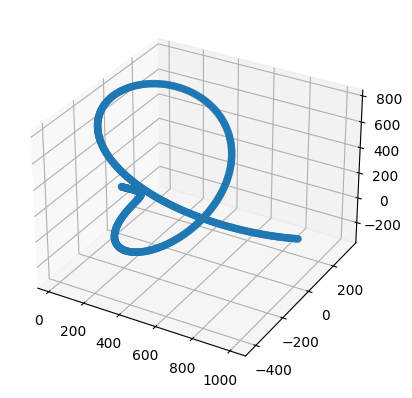

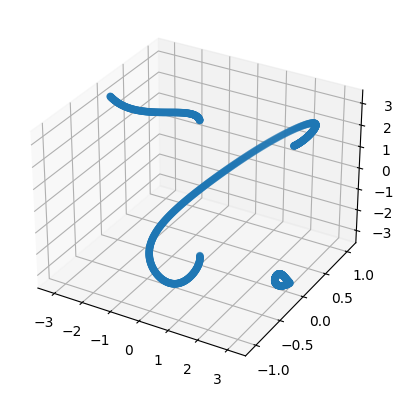

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(out[:,0], out[:,1], out[:,2])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(out[:,3], out[:,4], out[:,5])
plt.show()

In [25]:
for i in range(100):
    matplotlib.pyplot.close()


## Batch reverse transform from robot frame to world frame using torch

In [26]:
def to_world_torch(Robot_frame, P_relative):

    if Robot_frame.shape != P_relative.shape:
        raise ValueError("Input tensors must have same shape")

    if Robot_frame.shape[-1] != 6:
        raise ValueError("Input tensors must have last dim equal to 6")
        
    """ Assemble a batch of SE3 homogeneous matrices from a batch of 6DOF poses """
    batch_size = Robot_frame.shape[0]
    ones = torch.ones_like(P_relative[:, 0])
    transform = torch.zeros_like(Robot_frame)
    T1 = torch.zeros((batch_size, 4, 4), device=Robot_frame.device, dtype=Robot_frame.dtype)
    T2 = torch.zeros((batch_size, 4, 4), device=P_relative.device, dtype=P_relative.dtype)

    R1 = euler_to_rotation_matrix(Robot_frame[:, 3:])
    R2 = euler_to_rotation_matrix(P_relative[:, 3:])
    
    T1[:, :3, :3] = R1
    T2[:, :3, :3] = R2
    T1[:, :3,  3] = Robot_frame[:, :3]
    T2[:, :3,  3] = P_relative[:, :3]
    T1[:,  3,  3] = 1
    T2[:,  3,  3] = 1 

    T_tf = torch.matmul(T2, T1)
    
    transform[:, :3] = torch.matmul(T1, torch.cat((P_relative[:,:3], ones.unsqueeze(-1)), dim=1).unsqueeze(2)).squeeze()[:, :3]
    transform[:, 3:] = extract_euler_angles_from_se3_batch(T_tf)
    return transform

In [41]:
se3p1 = []
for i in range(100):
   se3p1.append([ i, 0, 0.0, np.pi/500 *i, np.pi/500 * 0, np.pi/500 * i]) 
se3p1 = np.array(se3p1, dtype=np.float32)

se3p2 = []
for i in range(1, 101):
   se3p2.append([ i, i, 0.0, np.pi/500 *0, np.pi/500 * 0, np.pi/500 * 0]) 
se3p2 = np.array(se3p2, dtype=np.float32)

se3c = se3p2 - se3p1

se3p1.shape, se3p2.shape

((100, 6), (100, 6))

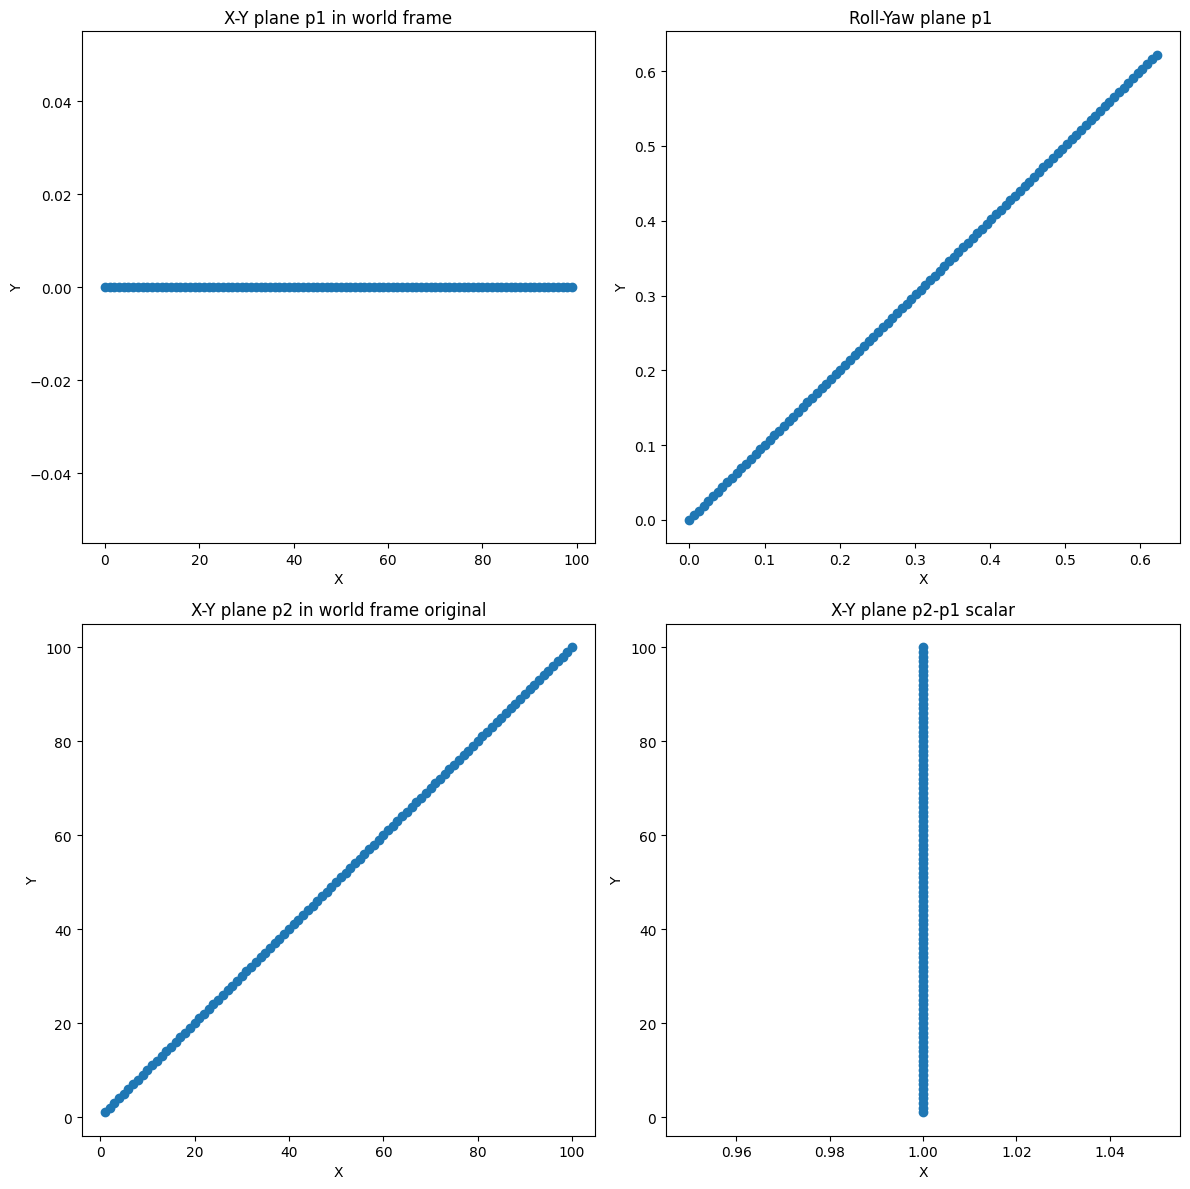

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 1 row, 3 columns of subplots

# First plot - se3p1
axs[0,0].scatter(se3p1[:, 0], se3p1[:, 1])
axs[0,0].set_title("X-Y plane p1 in world frame")
axs[0,0].set_xlabel("X")
axs[0,0].set_ylabel("Y")

# Second plot - se3p2
axs[1,0].scatter(se3p2[:, 0], se3p2[:, 1])
axs[1,0].set_title("X-Y plane p2 in world frame original")
axs[1,0].set_xlabel("X")
axs[1,0].set_ylabel("Y")

# Third plot - out
axs[0,1].scatter(se3p1[:, 3], se3p1[:, 5])
axs[0,1].set_title("Roll-Yaw plane p1 ")
axs[0,1].set_xlabel("X")
axs[0,1].set_ylabel("Y")

# Third plot - out
axs[1,1].scatter(se3c[:, 0], se3c[:, 1])
axs[1,1].set_title("X-Y plane p2-p1 scalar")
axs[1,1].set_xlabel("X")
axs[1,1].set_ylabel("Y")


plt.tight_layout()
plt.show()

In [43]:
outc =  to_robot_torch(torch.tensor(se3p1), torch.tensor(se3p2))
out  =  np.round(to_world_torch(torch.tensor(se3p1), outc), 4)

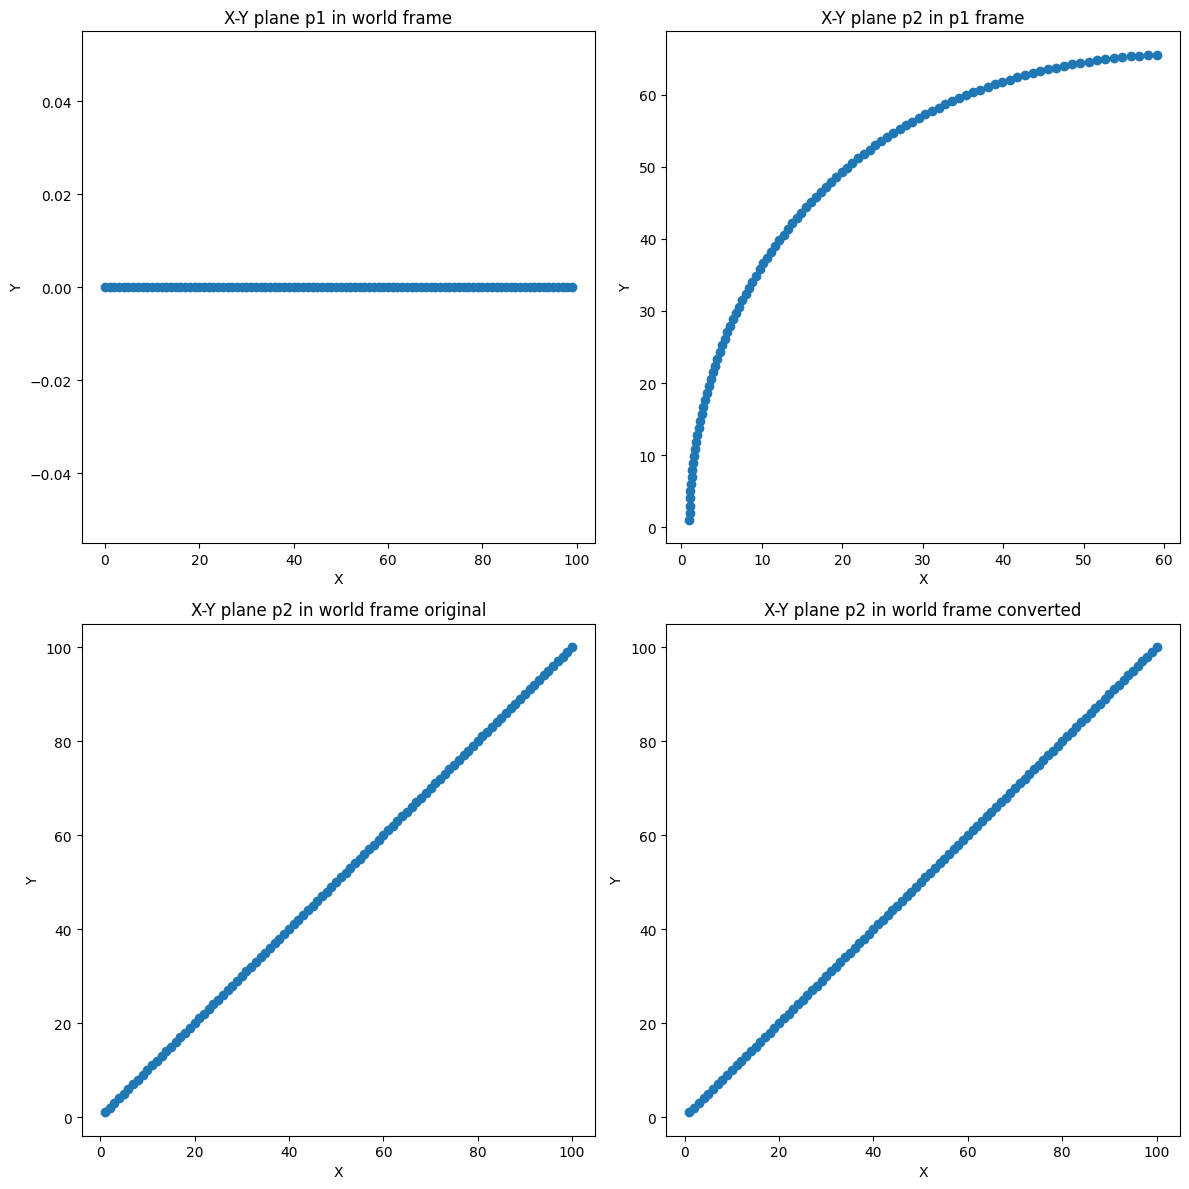

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 1 row, 3 columns of subplots

# First plot - se3p1
axs[0,0].scatter(se3p1[:, 0], se3p1[:, 1])
axs[0,0].set_title("X-Y plane p1 in world frame")
axs[0,0].set_xlabel("X")
axs[0,0].set_ylabel("Y")

# Second plot - se3p2
axs[1,0].scatter(se3p2[:, 0], se3p2[:, 1])
axs[1,0].set_title("X-Y plane p2 in world frame original")
axs[1,0].set_xlabel("X")
axs[1,0].set_ylabel("Y")

# Third plot - out
axs[0,1].scatter(outc[:, 0], outc[:, 1])
axs[0,1].set_title("X-Y plane p2 in p1 frame")
axs[0,1].set_xlabel("X")
axs[0,1].set_ylabel("Y")

# Third plot - out
axs[1,1].scatter(out[:, 0], out[:, 1])
axs[1,1].set_title("X-Y plane p2 in world frame converted")
axs[1,1].set_xlabel("X")
axs[1,1].set_ylabel("Y")

plt.tight_layout()
plt.show()

In [ ]:
def euler_to_rotation_matrix(euler_angles):
    """ Convert Euler angles to a rotation matrix """
    # Compute sin and cos for Euler angles
    cos = torch.cos(euler_angles)
    sin = torch.sin(euler_angles)
    zero = torch.zeros_like(euler_angles[:, 0])
    one = torch.ones_like(euler_angles[:, 0])
    # Constructing rotation matrices (assuming 'xyz' convention for Euler angles)
    R_x = torch.stack([one, zero, zero, zero, cos[:, 0], -sin[:, 0], zero, sin[:, 0], cos[:, 0]], dim=1).view(-1, 3, 3)
    R_y = torch.stack([cos[:, 1], zero, sin[:, 1], zero, one, zero, -sin[:, 1], zero, cos[:, 1]], dim=1).view(-1, 3, 3)
    R_z = torch.stack([cos[:, 2], -sin[:, 2], zero, sin[:, 2], cos[:, 2], zero, zero, zero, one], dim=1).view(-1, 3, 3)

    return torch.matmul(torch.matmul(R_z, R_y), R_x)
    
def extract_euler_angles_from_se3_batch(tf3_matx):
    # Validate input shape
    if tf3_matx.shape[1:] != (4, 4):
        raise ValueError("Input tensor must have shape (batch, 4, 4)")

    # Extract rotation matrices
    rotation_matrices = tf3_matx[:, :3, :3]

    # Initialize tensor to hold Euler angles
    batch_size = tf3_matx.shape[0]
    euler_angles = torch.zeros((batch_size, 3), device=tf3_matx.device, dtype=tf3_matx.dtype)

    # Compute Euler angles
    euler_angles[:, 0] = torch.atan2(rotation_matrices[:, 2, 1], rotation_matrices[:, 2, 2])  # Roll
    euler_angles[:, 1] = torch.atan2(-rotation_matrices[:, 2, 0], torch.sqrt(rotation_matrices[:, 2, 1] ** 2 + rotation_matrices[:, 2, 2] ** 2))  # Pitch
    euler_angles[:, 2] = torch.atan2(rotation_matrices[:, 1, 0], rotation_matrices[:, 0, 0])  # Yaw

    return euler_angles

def to_robot_torch(Robot_frame, P_relative):
    SE3 = True

    if not isinstance(Robot_frame, torch.Tensor):
        Robot_frame = torch.tensor(Robot_frame, dtype=torch.float32)
    
    if not isinstance(P_relative, torch.Tensor):
        P_relative = torch.tensor(P_relative, dtype=torch.float32)

    if len(Robot_frame.shape) == 1:
        Robot_frame = Robot_frame.unsqueeze(0)

    if len(P_relative.shape) == 1:
        P_relative = P_relative.unsqueeze(0)
  
    if len(Robot_frame.shape) > 2 or len(P_relative.shape) > 2:
        raise ValueError(f"Input must be 1D for  unbatched and 2D for batched got input dimensions {Robot_frame.shape} and {P_relative.shape}")
    
    if Robot_frame.shape != P_relative.shape:
        raise ValueError("Input tensors must have same shape")
    
    if Robot_frame.shape[-1] != 6 and Robot_frame.shape[-1] != 3:
        raise ValueError(f"Input tensors must have last dim equal to 6 for SE3 and 3 for SE2 got {Robot_frame.shape[-1]}")
    
    if Robot_frame.shape[-1] == 3:
        SE3 = False
        Robot_frame_ = torch.zeros((Robot_frame.shape[0], 6), device=Robot_frame.device, dtype=Robot_frame.dtype)
        Robot_frame_[:, [0,1,5]] = Robot_frame
        Robot_frame = Robot_frame_
        P_relative_ = torch.zeros((P_relative.shape[0], 6), device=P_relative.device, dtype=P_relative.dtype)
        P_relative_[:, [0,1,5]] = P_relative
        P_relative = P_relative_
        
    """ Assemble a batch of SE3 homogeneous matrices from a batch of 6DOF poses """
    batch_size = Robot_frame.shape[0]
    ones = torch.ones_like(P_relative[:, 0])
    transform = torch.zeros_like(Robot_frame)
    T1 = torch.zeros((batch_size, 4, 4), device=Robot_frame.device, dtype=Robot_frame.dtype)
    T2 = torch.zeros((batch_size, 4, 4), device=P_relative.device, dtype=P_relative.dtype)

    T1[:, :3, :3] = euler_to_rotation_matrix(Robot_frame[:, 3:])
    T2[:, :3, :3] = euler_to_rotation_matrix(P_relative[:, 3:])
    T1[:, :3,  3] = Robot_frame[:, :3]
    T2[:, :3,  3] = P_relative[:, :3]
    T1[:,  3,  3] = 1
    T2[:,  3,  3] = 1 
    
    T1_inv = torch.inverse(T1)
    tf3_mat = torch.matmul(T2, T1_inv)
    
    transform[:, :3] = torch.matmul(T1_inv, torch.cat((P_relative[:,:3], ones.unsqueeze(-1)), dim=1).unsqueeze(2)).squeeze(dim=2)[:, :3]
    transform[:, 3:] = extract_euler_angles_from_se3_batch(tf3_mat)
    
    if not SE3:
        transform = transform[:, [0,1,5]]
    
    return transform

def to_world_torch(Robot_frame, P_relative):
    SE3 = True

    if not isinstance(Robot_frame, torch.Tensor):
        Robot_frame = torch.tensor(Robot_frame, dtype=torch.float32)
    if not isinstance(P_relative, torch.Tensor):
        P_relative = torch.tensor(P_relative, dtype=torch.float32)

    if len(Robot_frame.shape) == 1:
        Robot_frame = Robot_frame.unsqueeze(0)

    if len(P_relative.shape) == 1:
        P_relative = P_relative.unsqueeze(0)
  
    if len(Robot_frame.shape) > 2 or len(P_relative.shape) > 2:
        raise ValueError(f"Input must be 1D for  unbatched and 2D for batched got input dimensions {Robot_frame.shape} and {P_relative.shape}")

    if Robot_frame.shape != P_relative.shape:
        raise ValueError("Input tensors must have same shape")
    
    if Robot_frame.shape[-1] != 6 and Robot_frame.shape[-1] != 3:
        raise ValueError(f"Input tensors 1 must have last dim equal to 6 for SE3 and 3 for SE2 got {Robot_frame.shape[-1]}")
    
    if P_relative.shape[-1] != 6 and P_relative.shape[-1] != 3:
        raise ValueError(f"Input tensors 2 must have last dim equal to 6 for SE3 and 3 for SE2 got {P_relative.shape[-1]}")
    
    if Robot_frame.shape[-1] == 3:
        SE3 = False
        Robot_frame_ = torch.zeros((Robot_frame.shape[0], 6), device=Robot_frame.device, dtype=Robot_frame.dtype)
        Robot_frame_[:, [0,1,5]] = Robot_frame
        Robot_frame = Robot_frame_
        P_relative_ = torch.zeros((P_relative.shape[0], 6), device=P_relative.device, dtype=P_relative.dtype)
        P_relative_[:, [0,1,5]] = P_relative
        P_relative = P_relative_
        
    """ Assemble a batch of SE3 homogeneous matrices from a batch of 6DOF poses """
    batch_size = Robot_frame.shape[0]
    ones = torch.ones_like(P_relative[:, 0])
    transform = torch.zeros_like(Robot_frame)
    T1 = torch.zeros((batch_size, 4, 4), device=Robot_frame.device, dtype=Robot_frame.dtype)
    T2 = torch.zeros((batch_size, 4, 4), device=P_relative.device, dtype=P_relative.dtype)

    R1 = euler_to_rotation_matrix(Robot_frame[:, 3:])
    R2 = euler_to_rotation_matrix(P_relative[:, 3:])
    
    T1[:, :3, :3] = R1
    T2[:, :3, :3] = R2
    T1[:, :3,  3] = Robot_frame[:, :3]
    T2[:, :3,  3] = P_relative[:, :3]
    T1[:,  3,  3] = 1
    T2[:,  3,  3] = 1 

    T_tf = torch.matmul(T2, T1)
    transform[:, :3] = torch.matmul(T1, torch.cat((P_relative[:, :3], ones.unsqueeze(-1)), dim=1).unsqueeze(2)).squeeze(dim=2)[:, :3]
    transform[:, 3:] = extract_euler_angles_from_se3_batch(T_tf)

    if not SE3:
        transform = transform[:, [0,1,5]]

    return transform
## -----
import tf.transformations
import tf
from geometry_msgs.msg import Quaternion

def angle_to_quaternion(angle):
    """Convert an angle in radians into a quaternion _message_."""
    if not isinstance(angle, np.ndarray):
        angle = np.array(angle, dtype=np.float32)
    if angle.shape[-1] != 3:
        raise ValueError(f"Input must have last dim equal to 3 got {angle.shape[-1]}")
    if len(angle.shape) > 2:
        raise ValueError(f"Input tensor must be 1D or 2D got {len(angle.shape)}")
    if len(angle.shape) == 1:
        return Quaternion(*tf.transformations.quaternion_from_euler(angle[0], angle[1], angle[2], axes='sxyz'))
    if len(angle.shape) == 2:
        return [Quaternion(*tf.transformations.quaternion_from_euler(ang_[0], ang_[1], ang_[2], axes='sxyz')) for ang_ in angle]
def quaternion_to_angle(q):
    """Convert a quaternion into an angle in radians."""
    if not isinstance(q, Quaternion) and not isinstance(q, list):
        raise ValueError(f"Input must be of type Quaternion or list of Quaternions")
    if isinstance(q, list):
        return np.array([tf.transformations.euler_from_quaternion((quat.x, quat.y, quat.z, quat.w), axes='sxyz') for quat in q], dtype=np.float32).tolist()
    if isinstance(q, Quaternion):
        return list(tf.transformations.euler_from_quaternion((q.x,q.y,q.z,q.w), axes='sxyz'))
















